In [1]:
# Load Libraries

import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
from numpy import linalg as la
from random import sample

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV


import pandas as pd

# Setting Constants

TI_limit = 25; 
TR = 7500; # (7.5 sesconds) T1 affects next slive

In [2]:
# Loading Confusion Matrix

conf_mat = np.load('conf_mat_combined.npy')
conf_mat.shape

(3, 3, 5)

In [3]:
# Normalising Matrices

def normalise_mat(C):
    C_n = C / C.astype(np.float).sum(axis=1, keepdims=True)
    # Correct, checked using: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    # Found at: https://stackoverflow.com/questions/20927368/python-how-to-normalize-a-confusion-matrix
    
    return C_n

conf_mat_n = np.zeros((3,3,5))

conf_mat_n[:,:,0] = normalise_mat(conf_mat[:,:,0])
conf_mat_n[:,:,1] = normalise_mat(conf_mat[:,:,1])
conf_mat_n[:,:,2] = normalise_mat(conf_mat[:,:,2])
conf_mat_n[:,:,3] = normalise_mat(conf_mat[:,:,3])
conf_mat_n[:,:,4] = normalise_mat(conf_mat[:,:,4])

In [4]:
# Calculating average confusion matrix
avg_conf = np.mean( np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2], conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )
std_conf = np.std(np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2], conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )
avg_conf_train = np.mean( np.array([ conf_mat_n[:,:,0],conf_mat_n[:,:,1],conf_mat_n[:,:,2]]), axis=0 )
avg_conf_test = np.mean( np.array([conf_mat_n[:,:,3], conf_mat_n[:,:,4] ]), axis=0 )

In [5]:
avg_conf

array([[9.95438121e-01, 4.42756025e-03, 1.34318334e-04],
       [7.70895787e-03, 9.77462331e-01, 1.48287112e-02],
       [0.00000000e+00, 2.87093672e-02, 9.71290633e-01]])

In [6]:
std_conf

array([[0.00614418, 0.00590754, 0.00026864],
       [0.00949832, 0.02729613, 0.01800444],
       [0.        , 0.0335824 , 0.0335824 ]])

In [7]:
# Calculating accuracy 

avg_acc = np.sum(np.diag(avg_conf))/np.sum(np.sum(avg_conf))
avg_acc_train = np.sum(np.diag(avg_conf_train))/np.sum(np.sum(avg_conf_train))
avg_acc_test = np.sum(np.diag(avg_conf_test))/np.sum(np.sum(avg_conf_test))

acc = np.zeros((5))

for i in range (5):
    acc[i] =  np.sum(np.diag(conf_mat_n[:,:,i]))/np.sum(np.sum(conf_mat_n[:,:,i]))

In [8]:
print('All:', avg_acc)
print('Test:', avg_acc_test)
print('Train:', avg_acc_train)

All: 0.98139702837368
Test: 0.9547164587876952
Train: 0.9991840747643367


In [9]:
acc

array([0.99952381, 0.99828209, 0.99974632, 0.9592912 , 0.95014171])

In [10]:
std_acc = np.std(acc)
std_acc_train = np.std(acc[0:3])
std_acc_test = np.std(acc[3:5])

In [11]:
print('All:', std_acc)
print('Test:', std_acc_test)
print('Train:', std_acc_train)

All: 0.021981557438633326
Test: 0.004574744810784792
Train: 0.0006442339628770763


In [11]:
def load_res(file_name):
    # Loading in Image

    img_nifti = nib.load(file_name)

    img =img_nifti.dataobj[:,:,:,:]
    
    classif = img[:,:,:,0]
    segment = img[:,:,:,1:4]

    return classif, segment

In [12]:
# Loading in Results

class_S1, seg_S1 = load_res('combined_rf_S1.nii')
class_S2, seg_S2 = load_res('combined_rf_S2.nii')
class_S3, seg_S3 = load_res('combined_rf_S3.nii')
class_S4, seg_S4 = load_res('combined_rf_S4.nii')
class_S5, seg_S5 = load_res('combined_rf_S5.nii')


In [13]:
# Checking Shape

print('class shape: ', np.shape(class_S1))
print('seg shape: ', np.shape(seg_S1))

class shape:  (77, 92, 56)
seg shape:  (77, 92, 56, 3)


In [14]:
# Combining into a List
class_list = [class_S1, class_S2, class_S3, class_S4, class_S5] 
seg_list = [seg_S1, seg_S2, seg_S3, seg_S4, seg_S5 ]

In [15]:
# Saving Lists

np.save('class_list_combined.npy', class_list, allow_pickle = True)
np.save('seg_list_combined.npy', seg_list, allow_pickle = True)

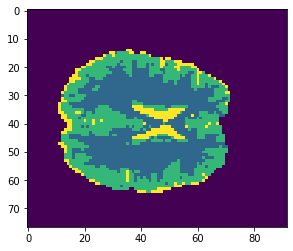

In [16]:
plt.imshow(class_list[0][:,:,33])

In [17]:
# Plotting everything for slice 33

def plotting_all_results(class_S, seg_S, z, n=5):
    fig = plt.gcf()
    fig.set_size_inches(20,20)

    for i in range (0,n):  
        plt.subplot(n, 4, 1+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(class_S[i][:,:,z])
        plt.subplot(n, 4, 2+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,0])
        plt.subplot(n, 4, 3+4*i)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(seg_S[i][:,:,z,1])
        plt.xticks([])
        plt.yticks([])
        plt.subplot(n, 4, 4+4*i)
        plt.imshow(seg_S[i][:,:,z,2])
        plt.xticks([])
        plt.yticks([])
    plt.subplots_adjust(wspace=0, hspace=0.05)
    

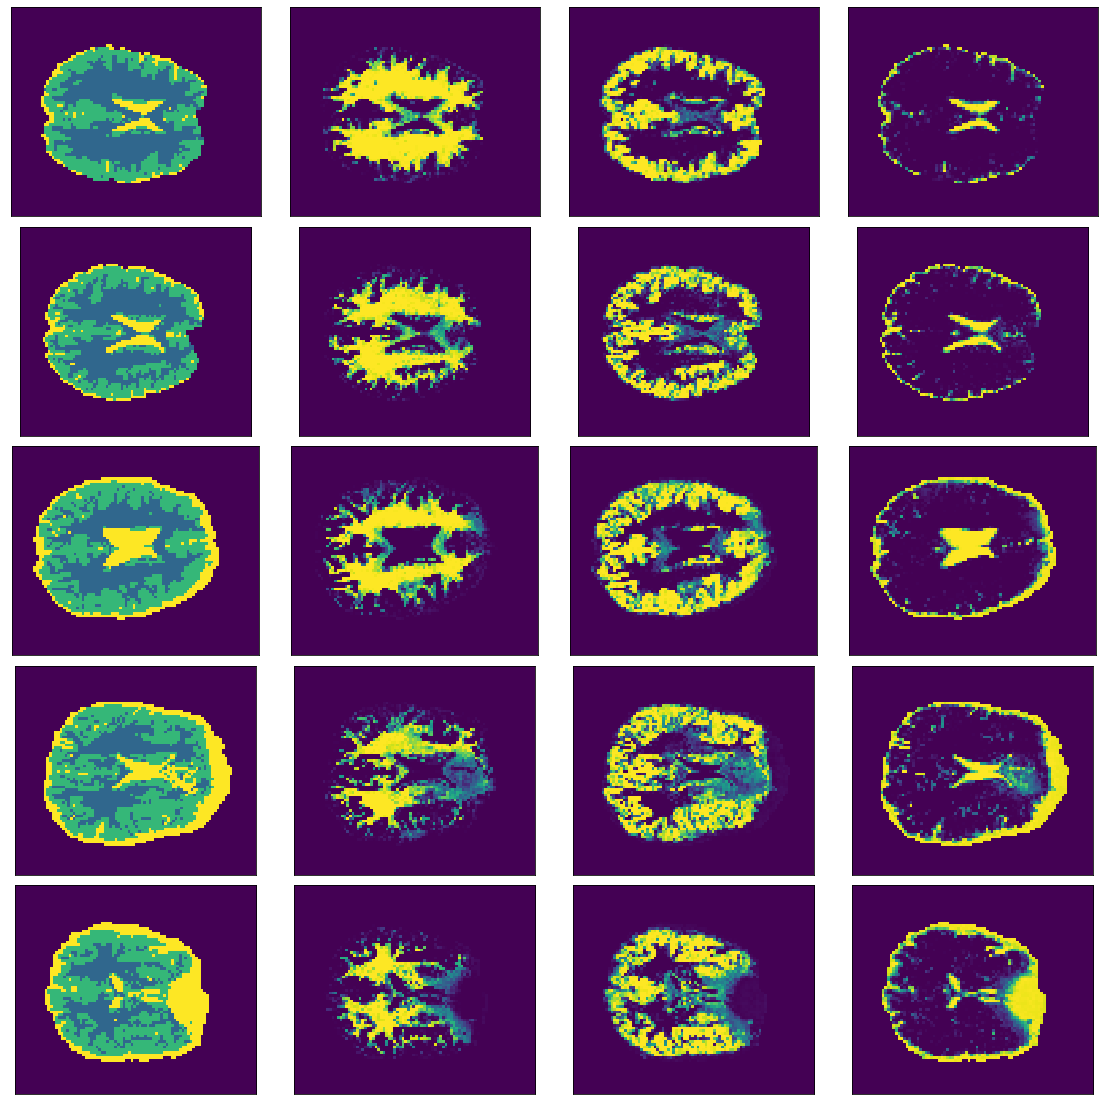

In [18]:
plotting_all_results(class_list, seg_list, 33)

<h2> Feature Importances </h2> 

In [2]:
feature_imp = np.loadtxt('combined_feature_imp.txt')
ind = np.loadtxt('combined_diff_ind.txt')

In [3]:
feature_imp.shape

(2, 86)

In [4]:
ind.shape

(86,)

In [5]:
feature_imp[0,:] = ind

In [6]:

sort_ind = np.argsort(feature_imp[0,:])
feature_imp_n = feature_imp[:, sort_ind]

In [7]:
feature_imp_n.shape

(2, 86)

In [8]:
feature_imp_n[0,:]

array([  22.,   26.,   49.,   50.,   51.,   52.,   52.,   53.,   53.,
         53.,   76.,   80.,  103.,  107.,  111.,  112.,  113.,  114.,
        114.,  130.,  134.,  157.,  161.,  184.,  188.,  208.,  209.,
        210.,  210.,  211.,  211.,  211.,  215.,  238.,  242.,  258.,
        259.,  260.,  261.,  261.,  265.,  269.,  277.,  278.,  279.,
        280.,  280.,  292.,  296.,  319.,  323.,  346.,  350.,  362.,
        363.,  364.,  365.,  365.,  373.,  377.,  378.,  379.,  380.,
        380.,  400.,  404.,  427.,  431.,  484.,  485.,  546.,  642.,
        643.,  693.,  712.,  797.,  812.,  916.,  917.,  978., 1074.,
       1075., 1125., 1144., 1229., 1244.])

Text(0, 0.5, 'Feature Importance')

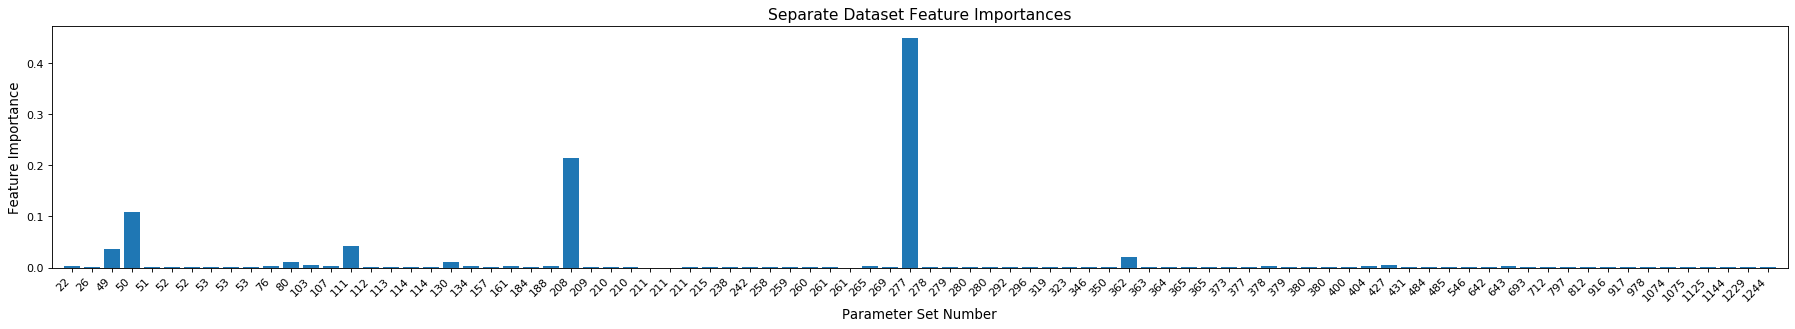

In [9]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(28, 4), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(86)
# plt.ylim([0,0.37])
plt.xlim([-1,86])
plt.bar(x, feature_imp_n[1,:])
plt.xticks(x, feature_imp_n[0,:].astype(int), rotation=45, ha="right")
plt.title('Separate Dataset Feature Importances', fontsize=14)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

In [10]:
feature_imp[0,:].astype(int)

array([  22,   26,   49,   53,   76,   80,  103,  107,  130,  134,  157,
        161,  184,  188,  211,  215,  238,  242,  265,  269,  292,  296,
        319,  323,  346,  350,  373,  377,  400,  404,  427,  431,   50,
         51,   52,   53,  111,  112,  113,  114,  208,  209,  210,  211,
        258,  259,  260,  261,  277,  278,  279,  280,  362,  363,  364,
        365,  378,  379,  380,   52,   53,  114,  210,  211,  261,  280,
        365,  380,  484,  485,  546,  642,  643,  693,  712,  797,  812,
        916,  917,  978, 1074, 1075, 1125, 1144, 1229, 1244])

In [11]:
feature_imp[:,feature_imp[0,:]==52]

array([[5.20000000e+01, 5.20000000e+01],
       [3.55229471e-04, 5.02222848e-04]])

In [12]:
most_imp = feature_imp[:,feature_imp[1,:]>0.02]

In [13]:
most_imp.shape

(2, 6)

Text(0, 0.5, 'Feature Importance')

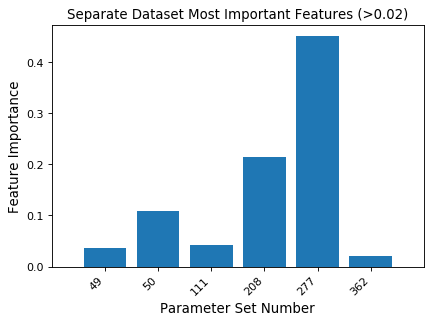

In [17]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(6, 4), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(6)
# plt.ylim([0,0.37])
plt.xlim([-1,6])
plt.bar(x, most_imp[1,:])
plt.xticks(x, most_imp[0,:].astype(int), rotation=45, ha="right")
plt.title('Separate Dataset Most Important Features (>0.02)', fontsize=12)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

Text(0, 0.5, 'Feature Importance')

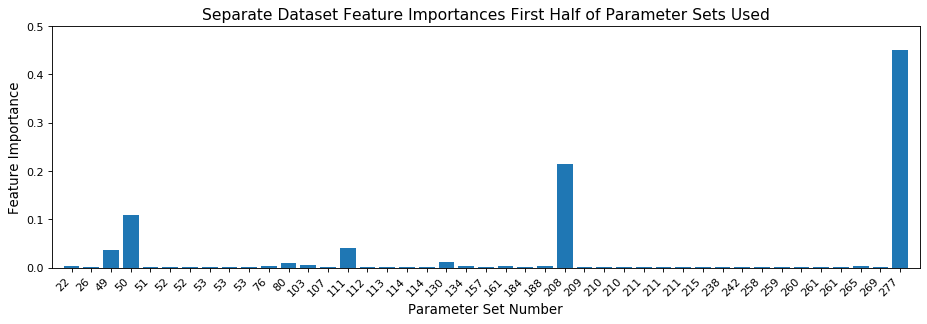

In [18]:
# Plotting Half
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(43)
plt.ylim([0,0.5])
plt.xlim([-1,43])
plt.bar(x, feature_imp_n[1,:43])
plt.xticks(x, feature_imp_n[0,:43].astype(int), rotation=45, ha="right")
plt.title('Separate Dataset Feature Importances First Half of Parameter Sets Used', fontsize=14)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)

Text(0, 0.5, 'Feature Importance')

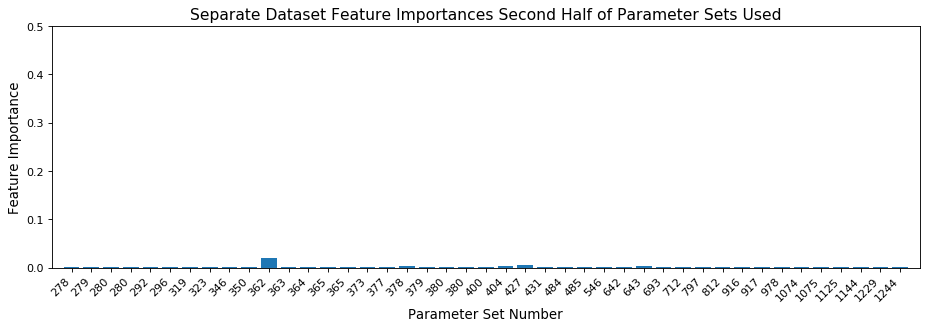

In [19]:
# Plotting Half
from matplotlib.pyplot import figure
figure(num=None, figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')
x = np.arange(43)
plt.ylim([0,0.5])
plt.xlim([-1,43])
plt.bar(x, feature_imp_n[1,43:])
plt.xticks(x, feature_imp_n[0,43:].astype(int), rotation=45, ha="right")
plt.title('Separate Dataset Feature Importances Second Half of Parameter Sets Used', fontsize=14)
plt.xlabel('Parameter Set Number', fontsize=12)
plt.ylabel('Feature Importance', fontsize=12)